In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from sklearn import metrics
import numpy as np
import pandas as pd
from collections import OrderedDict
from manifold_helper import ManifoldHelper


rng = np.random.default_rng(seed=42)

def plot_images(data, n_img_per_row=10, cmap='gray'):
    shape = int(np.sqrt(len(data[0])))
    # plot iage of the digits
    img = np.zeros( (shape * n_img_per_row, shape * n_img_per_row) )
    for i in range( n_img_per_row ):
        ix = shape * i
        for j in range( n_img_per_row ):
            iy = shape * j
            img[ix:ix + shape, iy:iy + shape] = data[i * n_img_per_row + j].reshape( (shape, shape) )

    plt.figure(figsize=(15, 15))
    plt.imshow( img, cmap=cmap )
    plt.xticks( [] )
    plt.yticks( [] )
    plt.show()

In [2]:
n_class = 10 # n primeiros digitos
data_percent = 0.05 # porcentagem dos dados de cada classa que serão usados
neighbors = [5, 8, 10, 12]
dimensions = [2, 3, 5, 10, 25, 50, 100]
methods = ['ISOMAP', 'LLE', 'SE', 'LTSA']

# Carregando os dados

In [3]:
datasetOriginal = pd.read_csv("data/mnist_train.csv")
df = datasetOriginal.copy()
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# separar os rotulos dos dados
label, x = df.iloc[:, :1], df.iloc[:, 1:]
label = label.to_numpy().transpose()[0]
x = x.to_numpy()
label, x

(array([5, 0, 4, ..., 5, 6, 8], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [5]:
# sort de acordo com os labels
idx = np.argsort(label)
label = label[idx]
x = x[idx]
label, x

(array([0, 0, 0, ..., 9, 9, 9], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [6]:
unique, counts = np.unique(label, return_counts=True)
num_data = dict(zip(unique, counts))
num_data

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

## Selecionando dados para analise

In [7]:
idx = np.random.RandomState(seed=42).permutation(len(x))
x = x[idx, :]
label = label[idx]
x_cut = x[:int(len(x) * data_percent), :]
label_cut = label[:int(len(x) * data_percent)]

unique, counts = np.unique(label_cut, return_counts=True)
num_data_cut = dict(zip(unique, counts))
num_data_cut, x_cut.shape

({0: 286,
  1: 353,
  2: 274,
  3: 316,
  4: 289,
  5: 290,
  6: 306,
  7: 307,
  8: 290,
  9: 289},
 (3000, 784))

In [8]:
label_colors = [list( mcolors.TABLEAU_COLORS )[i] for i in range( 10 )]
colors = [label_colors[v] for v in label_cut]

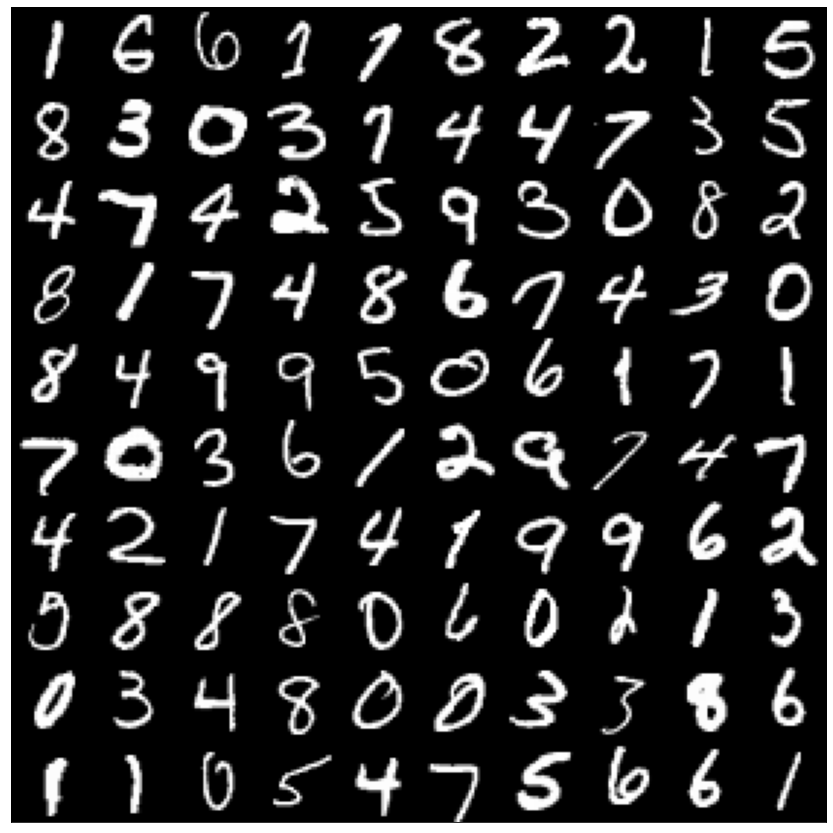

In [9]:
plot_images(x_cut)

# ARI

Gerando os métodos para cada valor de vizinhos no intervalo

In [10]:
manifold = ManifoldHelper(neighbors, dimensions, methods, alternative_LTSA=True)

Using alternative LTSA.


In [11]:
import warnings
warnings.filterwarnings('ignore')
ari_results = manifold.evaluate_all(x_cut, label_cut, n_components=n_class)


2_dimension:
   5_neighbors: 0.32(3.4s)  0.40(0.7s)  0.39(0.5s)  -0.00(16.5s) 
   8_neighbors: 0.27(3.9s)  0.40(1.3s)  0.39(0.6s)  0.24(16.8s) 
   10_neighbors: 0.30(4.1s)  0.35(1.3s)  0.36(0.8s)  0.30(16.9s) 
   12_neighbors: 0.29(4.4s)  0.38(1.3s)  0.36(0.7s)  0.36(16.9s) 
3_dimension:
   5_neighbors: 0.31(3.4s)  0.44(0.7s)  0.45(0.5s)  -1.00(-1.0s) 
   8_neighbors: 0.28(3.9s)  0.43(1.3s)  0.44(0.6s)  0.00(16.8s) 
   10_neighbors: 0.28(4.1s)  0.41(1.4s)  0.47(0.7s)  0.27(17.1s) 
   12_neighbors: 0.28(4.3s)  0.41(1.3s)  0.44(0.8s)  0.36(17.1s) 
5_dimension:
   5_neighbors: 0.52(3.5s)  0.48(0.7s)  0.50(0.5s)  -1.00(-1.0s) 
   8_neighbors: 0.45(3.8s)  0.44(1.2s)  0.50(0.6s)  0.00(16.4s) 
   10_neighbors: 0.40(4.1s)  0.37(1.4s)  0.50(0.7s)  0.35(16.8s) 
   12_neighbors: 0.50(4.3s)  0.35(1.3s)  0.50(0.7s)  0.38(17.0s) 
10_dimension:
   5_neighbors: 0.52(4.4s)  0.49(1.4s)  0.65(0.5s)  -1.00(-1.0s) 
   8_neighbors: 0.56(4.8s)  0.45(1.5s)  0.62(0.6s)  -1.00(-1.0s) 
   10_neighbors: 0.57(4.9

In [12]:
manifold.evaluate_gmm_ari(x_cut, label_cut, n_class)

0.36818783331318994

In [29]:
random_label = np.random.default_rng(42).integers(0, n_class, size=len(x_cut))
random_ari = metrics.adjusted_rand_score(random_label, label_cut)
print(f'ARI com labels randômicos: {random_ari:.2f}')

ARI com labels randômicos: -0.00


In [13]:
manifold.saveARI(ari_results, add='id_23')

[[0.31911907 0.2726342  0.30220445 0.2881423 ]
 [0.30824439 0.27562502 0.27863062 0.28488622]
 [0.52226861 0.45138687 0.39837769 0.49755735]
 [0.51861567 0.5609111  0.57090957 0.57287744]
 [0.55258665 0.61489534 0.53942111 0.52737518]
 [0.55103122 0.5900757  0.52301375 0.56552678]
 [0.56839227 0.44085142 0.48044821 0.44901073]]
[[0.39903755 0.39596023 0.34504363 0.37934739]
 [0.44427965 0.42570021 0.4134656  0.41262608]
 [0.47583982 0.44314086 0.36750278 0.34750352]
 [0.49183419 0.44922061 0.42134678 0.37902529]
 [0.610336   0.52166151 0.53050872 0.49304714]
 [0.57224602 0.60361343 0.44896922 0.47042315]
 [0.51847106 0.49878371 0.52371162 0.58722659]]
[[0.39257634 0.39386179 0.36454986 0.35554523]
 [0.45001207 0.43535279 0.46836352 0.43913481]
 [0.50485891 0.50111161 0.5018249  0.49621614]
 [0.65263038 0.62428162 0.53723441 0.63826202]
 [0.53695831 0.61773538 0.61404317 0.58073849]
 [0.62080874 0.64604946 0.51279422 0.6208733 ]
 [0.58836442 0.54287428 0.52725024 0.52423677]]
[[-3.23997

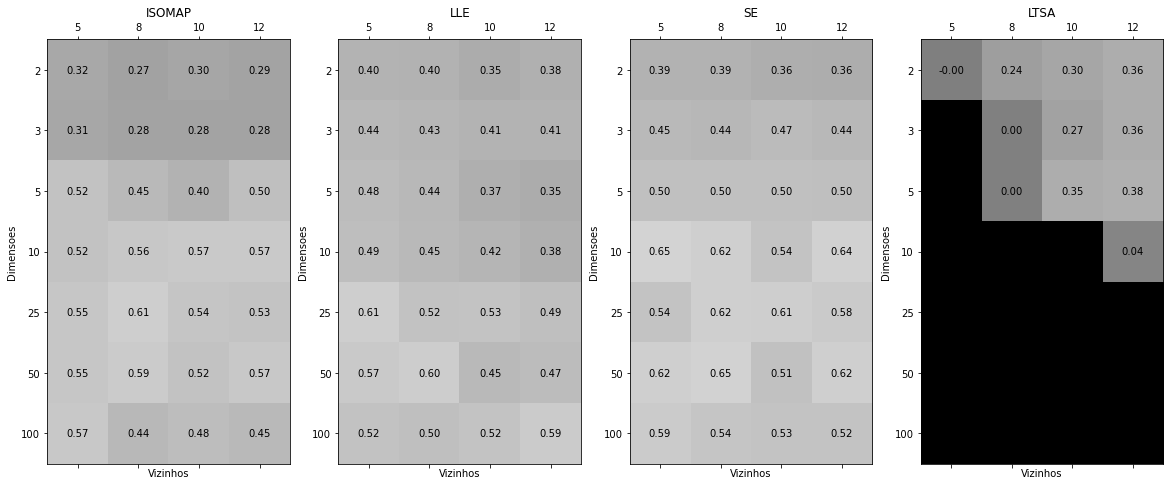

In [14]:
manifold.plot_ari_results(ari_results, neighbors, dimensions)